# Лабораторная работа 9


## Нелинейная краевая задача
## Подзадача: задача Штурма-Лиувилля на собственные значения

In [1]:
import numpy as np                # импорт бибилиотеки numpy
import matplotlib.pyplot as plt   # импорт модуля matplotlib.pyplot
import scipy.integrate as integrate # импорт модуля численного интегрирования
import sympy as sym
import scipy as sp
import scipy.optimize as op
import pandas as pd
import copy
import numbers
import math
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

### Задача:

ВЫБРАТЬ ЛЮБУЮ постановку из XI.9.2. или XI.9.3. и решить её методом стрельбы И методом квазилинеаризации Ньютона (проверить сходимость решения по расчетной сетке).

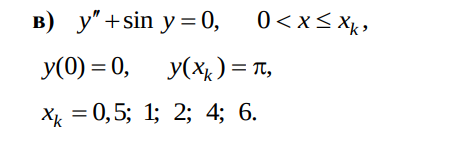

### Исходные данные:

In [5]:
f = lambda x, y: [y[1], -np.sin(y[0])]
x_k = [0.5, 1.0, 2.0, 4.0, 6.0]

## Метод стрельбы

In [45]:
# Error for F(s) = y(xk) - pi
def error_function_lambda(s, current_xk):
    y0 = [0.0, s]
    sol = solve_ivp(f, [0, current_xk], y0, dense_output=True, method='RK45', rtol=1e-8, atol=1e-8)
    y_xk = sol.sol(current_xk)[0]
    return y_xk - np.pi

def shooting_method(f, x_k):
    results_shooting_lambda = {}
    for loop_xk in x_k:
        initial_guess_s = np.pi / loop_xk

        # находим интервал для s, с помощью изменения знака в ошибке
        s_interval = None
        potential_intervals = [(initial_guess_s / 2, initial_guess_s * 2), (0.1, 10.0), (-10.0, 10.0), (0.01, 50.0), (-50.0, 50.0)]
        for a, b in potential_intervals:
            f_a = error_function_lambda(a, loop_xk)
            f_b = error_function_lambda(b, loop_xk)
            if f_a * f_b < 0:
                s_interval = (a, b)
                print(f"найден интервал для s: [{a:.4f}, {b:.4f}]")
                break
    
        # Поиск корня s
        if s_interval:
            sol_root = root_scalar(error_function_lambda, args=(loop_xk,), bracket=s_interval, method='brentq', xtol=1e-9)
            s_optimal = sol_root.root
        else:
            sol_root = root_scalar(error_function_lambda, args=(loop_xk,), x0=initial_guess_s, method='secant', xtol=1e-9, maxiter=200)
            if not sol_root.converged:
                 print(f"Secant failed with initial guess {initial_guess_s:.4f}, trying s=1.0")
                 sol_root = root_scalar(error_function_lambda, args=(loop_xk,), x0=1.0, method='secant', xtol=1e-9, maxiter=200)
                 if not sol_root.converged:
                      raise RuntimeError(f"Root finding failed to converge for x_k = {loop_xk}")
            s_optimal = sol_root.root
    
        print(f"оптимальный начальный наклон s = y'(0) = {s_optimal:.8f}")
    
        # задачу Коши с найденным s используя f
        y0_optimal = [0.0, s_optimal]
        sol_final = solve_ivp(f,
                              [0, loop_xk], y0_optimal, dense_output=True, method='RK45', rtol=1e-9, atol=1e-9)
    
        results_shooting_lambda[loop_xk] = sol_final
        print(f"Проверка решения: y({loop_xk}) = {sol_final.sol(loop_xk)[0]:.8f}")
    
    return results_shooting_lambda


In [46]:
results_shooting_lambda = shooting_method(f, x_k)


найден интервал для s: [3.1416, 12.5664]
оптимальный начальный наклон s = y'(0) = 6.44332232
Проверка решения: y(0.5) = 3.14159266
найден интервал для s: [1.5708, 6.2832]
оптимальный начальный наклон s = y'(0) = 3.46711826
Проверка решения: y(1.0) = 3.14159266
найден интервал для s: [0.7854, 3.1416]
оптимальный начальный наклон s = y'(0) = 2.24422129
Проверка решения: y(2.0) = 3.14159266
найден интервал для s: [0.1000, 10.0000]
оптимальный начальный наклон s = y'(0) = 2.00531770
Проверка решения: y(4.0) = 3.14159271
найден интервал для s: [0.1000, 10.0000]
оптимальный начальный наклон s = y'(0) = 2.00009829
Проверка решения: y(6.0) = 3.14159308


<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_386472/3261517347.py:11: SyntaxWarning: invalid escape sequence '\p'
  plt.axhline(np.pi, color='r', linestyle=':', label='$y=\pi$')


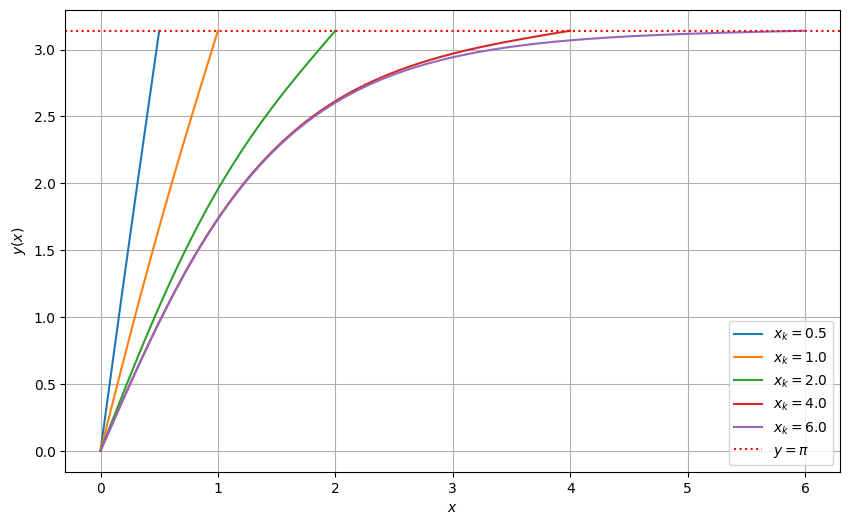

In [47]:

plt.figure(figsize=(10, 6))
for current_xk, sol in results_shooting_lambda.items():
    if sol:
        x_plot = np.linspace(0, current_xk, 200)
        y_plot = sol.sol(x_plot)[0]
        plt.plot(x_plot, y_plot, label=f'$x_k = {current_xk}$')


plt.xlabel('$x$')
plt.ylabel('$y(x)$')
plt.axhline(np.pi, color='r', linestyle=':', label='$y=\pi$')
plt.legend()
plt.grid(True)
plt.show()

## Метод квазилинеаризации Ньютона

In [43]:
from scipy.linalg import solve_banded

def solve_quasilin_newton(xk_list, ode_info, N=100, max_iter=50, tol=1e-8):
    
    results = {}
    g_func, g_prime_func = ode_info

    for xk in xk_list:
        h = float(xk) / N
        x_grid = np.linspace(0, xk, N + 1)
        y = np.linspace(0, np.pi, N + 1) # нач приближение

        converged = False
        for k in range(max_iter):
            F = np.zeros(N - 1)
            J_banded = np.zeros((3, N - 1))

            for i in range(N - 1):
                idx = i + 1
                y_i = y[idx]
                y_prev = y[idx - 1]
                y_next = y[idx + 1]
                F[i] = y_next - 2 * y_i + y_prev + h**2 * g_func(y_i) 
                J_banded[1, i] = -2.0 + h**2 * g_prime_func(y_i)
                if i > 0: J_banded[2, i] = 1.0
                if i < N - 2: J_banded[0, i+1] = 1.0

            delta_y = solve_banded((1, 1), J_banded, -F) # решаем Ax=b для трехдиагональной матрицы 

            y[1:-1] += delta_y
            norm_delta = np.linalg.norm(delta_y) if delta_y is not None else float('inf')
            # print(f"На {k+1}: ||delta_y|| = {norm_delta:.4e}")
            if norm_delta < tol:
                print(f"Сошлась на {k+1} шаге")
                converged = True
                break

        if converged and delta_y is not None: 
            results[xk] = (x_grid, y)
        else: 
            print(f"не сошлась для x_k = {xk}")
            results[xk] = None

    return results

<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_386472/1684255710.py:20: SyntaxWarning: invalid escape sequence '\p'
  plt.axhline(np.pi, color='r', linestyle=':', label='$y=\pi$')


Сошлась на 23 шаге
Сошлась на 25 шаге
Сошлась на 27 шаге
Сошлась на 22 шаге
Сошлась на 50 шаге


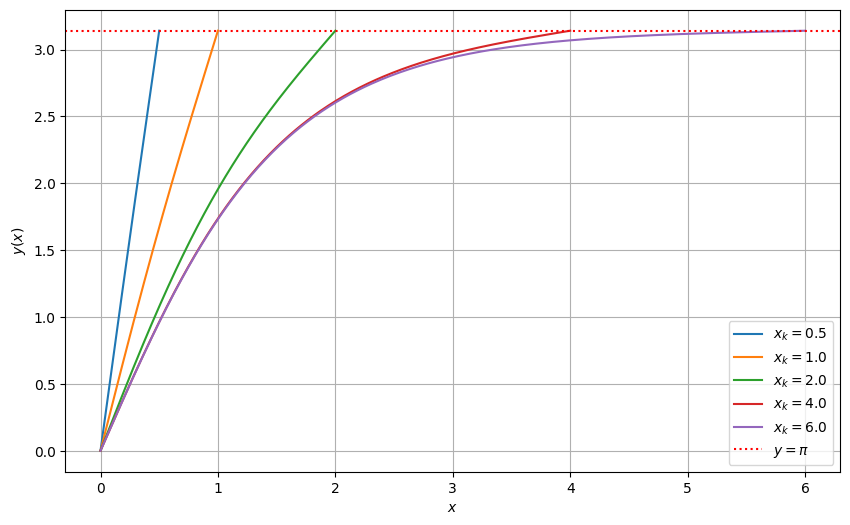

In [48]:
from scipy.interpolate import interp1d

N_grid = 200

results_quasi = solve_quasilin_newton(x_k, (np.sin, np.cos), N=N_grid, tol=1e-9, max_iter=100)
# ---------------------------------------------^ ------^ сама функия и её производная

plt.figure(figsize=(10, 6))
for current_xk, result_data in results_quasi.items():
    x_grid, y_sol = result_data

    interp_func = interp1d(x_grid, y_sol, kind='cubic', bounds_error=False, fill_value="extrapolate")
    x_plot = np.linspace(0, current_xk, 300)
    y_plot = interp_func(x_plot)
    plt.plot(x_plot, y_plot, label=f'$x_k = {current_xk}$')


plt.xlabel('$x$')
plt.ylabel('$y(x)$')
plt.axhline(np.pi, color='r', linestyle=':', label='$y=\pi$')
plt.legend()
plt.grid(True)
plt.show()

# Подзадача
ВЫБРАТЬ ЛЮБУЮ задачу из XI.9.14 , XI.9.16, XI.9.19 - отыскать спектр и соответствующие собственные функции в условиях задачи обычными подходами. Попробовать применить метод дополненного вектора (перейти к решению нелинейной системы, при этом при использовании метода Ньютона возникнет трехдиагональная матрица).
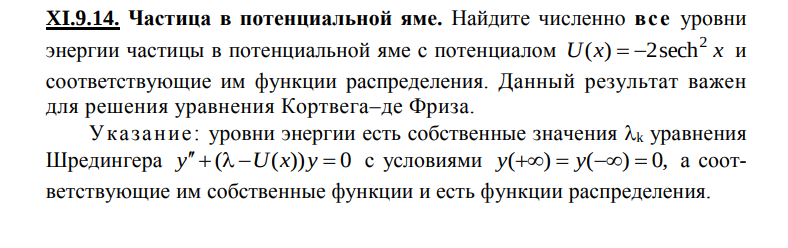

In [85]:
potential_U = lambda x: -2.0 / (np.cosh(x)**2)

In [93]:
rtol=1e-8
atol=1e-10
xtol=1e-10

# ещё один метод стрельбы только уже для нынешней постановки задачи и нахдящий собственные значения
def solve_shooting_eigenvalue(potential_func, L, lambda_bounds):
    def ode_system_eigen(x, y_vec, current_lam):
        y1, y2 = y_vec
        dy1dx = y2
        dy2dx = (potential_func(x) - current_lam) * y1
        return [dy1dx, dy2dx]

    def error_for_lambda(lam, L_err, y0_tuple_err):
        sol = solve_ivp(ode_system_eigen, [0, L_err], y0_tuple_err, args=(lam,),
                            method='RK45', dense_output=True, rtol=rtol, atol=atol)
        y1_L = sol.sol(L_err)[0]
        return y1_L
    
    def find_single_eigenvalue(y0_tuple, parity_name):
        lambda_found = None
        solution_data = None

        sol_root = root_scalar(error_for_lambda,
                               args=(L, y0_tuple),
                               bracket=lambda_bounds, method='brentq', xtol=xtol)

        lambda_found = sol_root.root
        print(f"Найдено {parity_name} собственное значение: lambda = {lambda_found:.8f}")

        sol_half = solve_ivp(ode_system_eigen, [0, L], y0_tuple, args=(lambda_found,),
                             method='RK45', dense_output=True, rtol=rtol, atol=atol)
        x_fine = np.linspace(-L, L, 501)
        y_fine = np.zeros_like(x_fine)
        mask_pos = x_fine >= 0; mask_neg = x_fine < 0
        y_fine[mask_pos] = sol_half.sol(x_fine[mask_pos])[0]
        if y0_tuple[1] == 0:
            y_fine[mask_neg] = sol_half.sol(-x_fine[mask_neg])[0]
        else:
            y_fine[mask_neg] = -sol_half.sol(-x_fine[mask_neg])[0]

        norm_sq, _ = quad(lambda x: sol_half.sol(abs(x))[0]**2, -L, L, limit=200, epsabs=1e-9)
        norm = np.sqrt(norm_sq)

        y_fine /= norm
        solution_data = (x_fine, y_fine)

        return lambda_found, solution_data

    all_eigenvalues = []
    all_eigenfunctions = []
    y0_even = (1.0, 0.0)
    lambda_even, eigenfunction_even = find_single_eigenvalue(y0_even, "ЧЕТНЫХ")

    all_eigenvalues.append(lambda_even)
    all_eigenfunctions.append(eigenfunction_even)

    y0_odd = (0.0, 1.0)

    try:
      lambda_odd, eigenfunction_odd = find_single_eigenvalue(y0_odd, "НЕЧЕТНЫХ")
      if lambda_odd is not None: # Эта проверка осталась, т.к. функция может вернуть None
          all_eigenvalues.append(lambda_odd)
          all_eigenfunctions.append(eigenfunction_odd)
    except ValueError:
        print("  Корень/интервал для НЕЧЕТНЫХ решений не найден.")


    return all_eigenvalues, all_eigenfunctions


# вместо метода Ньютона, тк по-идее, если использовать его то не получиться трехдиагональной матрицы во время решения
def solve_inverse_iteration(potential_func, L, N, sigma, max_iter=100, tol=1e-10):
    h = 2.0 * L / N
    x_grid_inner = np.linspace(-L + h, L - h, N - 1)
    x_full_grid = np.linspace(-L, L, N + 1)
    U_grid = potential_func(x_grid_inner)
    
    d = 2.0 / h**2 + U_grid
    e = -1.0 / h**2 * np.ones(N - 2)
    d_shifted = d - sigma
    
    B_banded = np.zeros((3, N - 1))
    B_banded[0, 1:] = e; B_banded[1, :] = d_shifted; B_banded[2, :-1] = e
    y_k = np.random.rand(N - 1); y_k = y_k / np.linalg.norm(y_k)

    lambda_k = sigma
    lambda_found = None
    solution_data = None

    for k in range(max_iter):

        z_k_plus_1 = la.solve_banded((1, 1), B_banded, y_k)
        norm_z = np.linalg.norm(z_k_plus_1)

        y_k_plus_1 = z_k_plus_1 / norm_z
        Ay_k1 = np.zeros_like(y_k_plus_1)
        Ay_k1[0] = d[0] * y_k_plus_1[0] + e[0] * y_k_plus_1[1]
        for i in range(1, N - 2): Ay_k1[i] = e[i-1] * y_k_plus_1[i-1] + d[i] * y_k_plus_1[i] + e[i] * y_k_plus_1[i+1]
        
        Ay_k1[N-2] = e[N-3] * y_k_plus_1[N-3] + d[N-2] * y_k_plus_1[N-2]
        lambda_k_plus_1 = np.dot(y_k_plus_1, Ay_k1)
        diff_lambda = np.abs(lambda_k_plus_1 - lambda_k)
        
        print(f"  Iter {k+1}: lambda = {lambda_k_plus_1:.8f}, diff_lambda = {diff_lambda:.4e}")
        
        if diff_lambda < tol:
            print(f"Сошлось после {k+1} итераций")
            y_normalized = y_k_plus_1 / np.sqrt(h)
            y_full = np.concatenate(([0], y_normalized, [0]))
            lambda_found = lambda_k_plus_1
            solution_data = (x_full_grid, y_full)
            break

        y_k = y_k_plus_1; lambda_k = lambda_k_plus_1

    return lambda_found, solution_data



Найдено ЧЕТНЫХ собственное значение: lambda = -1.00000000
  Корень/интервал для НЕЧЕТНЫХ решений не найден.
  Iter 1: lambda = -0.99949807, diff_lambda = 9.4981e-03
  Iter 2: lambda = -1.00000870, diff_lambda = 5.1062e-04
  Iter 3: lambda = -1.00000874, diff_lambda = 4.5039e-08
  Iter 4: lambda = -1.00000874, diff_lambda = 4.1147e-12
Сошлось после 4 итераций
Метод стрельбы нашел уровни: [-1.0000000002819787]
Метод обратных итераций нашел уровни: [-1.0000087415531165]


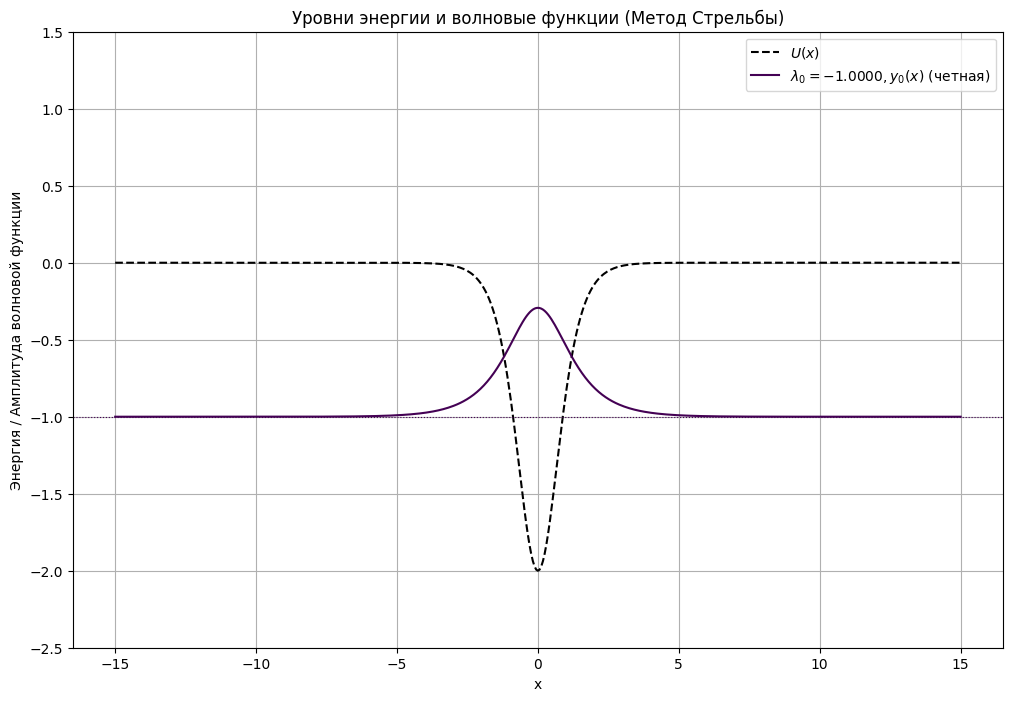

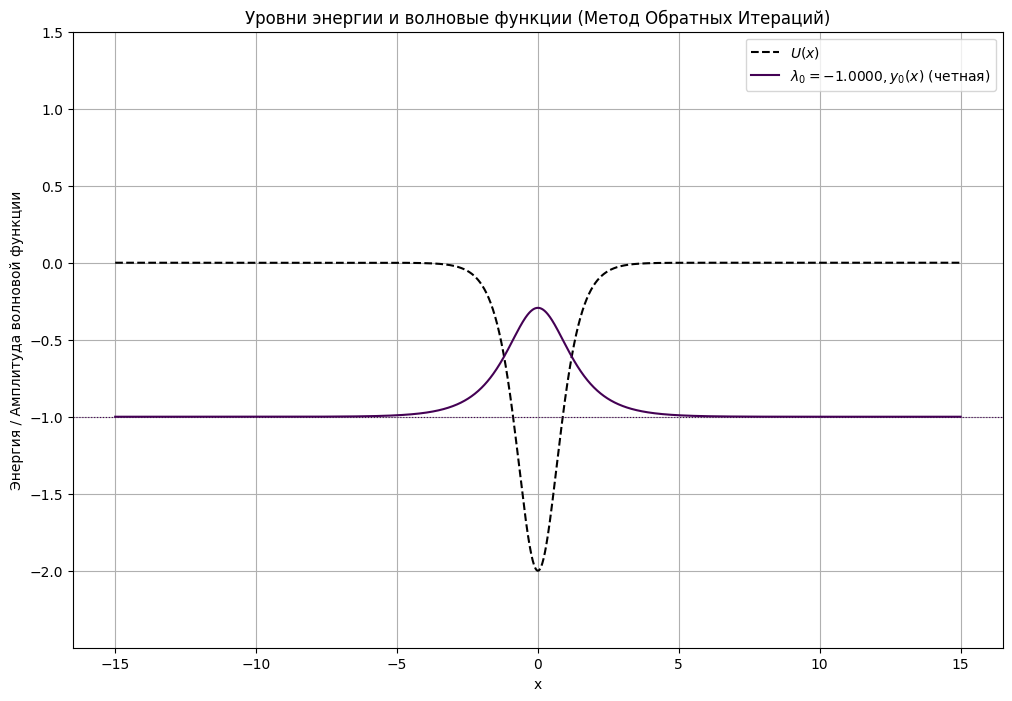

In [94]:

def plot_results(potential_func, eigenvalues, eigenfunctions_data, method_name, L):
    plt.figure(figsize=(12, 8))
    x_plot = eigenfunctions_data[0][0]
    U_plot = potential_func(x_plot)
    plt.plot(x_plot, U_plot, 'k--', label=f'$U(x)$')
    colors = plt.cm.viridis(np.linspace(0, 1, max(1, len(eigenvalues))))

    for i, lam in enumerate(eigenvalues):
        x_grid, y_normalized = eigenfunctions_data[i]
        mid_index = len(x_grid) // 2

        is_even = np.abs(y_normalized[mid_index-1] - y_normalized[mid_index+1]) < np.abs(y_normalized[mid_index-1] + y_normalized[mid_index+1])
        label_suffix = " (четная)" if is_even else " (нечетная)"
        plt.plot(x_grid, y_normalized + lam, color=colors[i], label=fr'$\lambda_{i} = {lam:.4f}, y_{i}(x)${label_suffix}')
        plt.axhline(lam, color=colors[i], linestyle=':', linewidth=0.8)
    
    plt.ylim(min(U_plot) - 0.5, max(0, max(eigenvalues) if len(eigenvalues) > 0 else 0) + 1.5)
    plt.title(f'Уровни энергии и волновые функции ({method_name})')
    plt.xlabel('x')
    plt.ylabel('Энергия / Амплитуда волновой функции')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


L_boundary = 15.0
lambda_search_bounds = (-1.9999, -0.0001)
N_grid_points_inv_iter = 2001
sigma_shift = -0.99

eigenvalues_shoot, eigenfunctions_shoot = solve_shooting_eigenvalue(
    potential_U, L_boundary, lambda_search_bounds
)

lambda_inv_iter, eigenfunction_inv_iter_data = solve_inverse_iteration(
    potential_U, L_boundary, N_grid_points_inv_iter, sigma=sigma_shift, tol=1e-9
)

eigenvalues_inv_iter = []
eigenfunctions_inv_iter = []

eigenvalues_inv_iter.append(lambda_inv_iter)
eigenfunctions_inv_iter.append(eigenfunction_inv_iter_data)

print("Метод стрельбы нашел уровни:", eigenvalues_shoot)
print("Метод обратных итераций нашел уровни:", eigenvalues_inv_iter)

plot_results(potential_U, eigenvalues_shoot, eigenfunctions_shoot, "Метод Стрельбы", L_boundary)
plot_results(potential_U, eigenvalues_inv_iter, eigenfunctions_inv_iter, "Метод Обратных Итераций", L_boundary)
